In [165]:
def jitterpipe(dirpath, psrname, MJDint, clearoutput=True, cal=True, zap=True, scrunch=True, timing=True, resids=True):
    
    '''
    Jitterpipe
    6/27/2016

    Modified version of Michael Lam's pipeline by Ellianna Schwab with help from Michael Lam and Scott Ransom.
    Michael Lam's original pipeline is here: http://astro.cornell.edu/~mlam/files/pipeline.py

    Reduction pipeline for any NANOGrav input data. Time scrunches to two intervals for jitter analysis.
    This assumes all the incoming parfiles are .gls.par!

    Takes arguments as 
    jitterpipe(dirpath, psrname, MJDint, clearoutput=True, cal=True, zap=True, scrunch=True, timing=True, resids=True)

        dirpath is the directory that contains the pulsar's files. to run, store cf and rf files in a folder /folded.

        psrname is the name of the psr as displayed in par and sum.sm files, such as J1713+0747

        MJDint takes in the brightest MJD date and creates a plot interval on that date

        clearoutput takes True or False, clears all prior reduction folders and files

        cal takes True or False, makes calib files and stores them in calib/

        zap takes True or False, removes the RFI and makes zap files from the calibrated files

        scrunch takes True or False, scrunches the files to 10s and 80s subints, with 8 subchannels

        timing takes True or False, creates TOAs and tim files for  both sets of scrunched files

        resids takes True or False, creates plots to show the jitter on the MJD day with brightest flux for that object

    '''
    
    ## ==============================
    ## Imports and Definitions
    ## ==============================

    import os #provides uniform interface to a number of OS functions
    import sys #contains useful functions and variables
    import subprocess #processes that run as independent entities
    import glob #finds all pathnames matching a specified pattern

    import residuals as r #brings in Scott's residuals
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    import math

    OUTPUT_FRONT = "jitterpipe: "
    DIR = dirpath #ex. /nimrod1/eschwab/B1937_data/
    PARFILE = DIR + "%s_NANOGrav_11yv0.par" %psrname 
    TEMPLATEFILE = DIR + "%s.L-wide.PUPPI.11y.x.sum.sm" %psrname 

    def call(x): 
        subprocess.call(x,shell=True)
    def printer(x):
        print(OUTPUT_FRONT+x)
    def add_header (filename, line):
        with open(filename, 'r+') as f:
            content=f.read()
            f.seek(0,0)
            f.write(line.rstrip('\r\n') + '\n' + content)
        

    ## ==============================
    ## Choose Sections to Run
    ## ==============================

    printer("Running %s jitterpipe reduction pipeline" %psrname)

    CLEARFLAG = clearoutput
    CALFLAG = cal
    ZAPFLAG = zap
    SPLITFLAG = scrunch
    TIMFLAG = timing
    RESIDFLAG = resids

    #DMPRINTERFLAG = F 
    

    ## ==============================
    ## Clear old version
    ## ==============================

    ## Runs a bash script to rm old files and prints out deletion complete

    if CLEARFLAG:
        printer("Deleting old version")
        call("rm -rf %scal" %DIR)
        call("rm -rf %scalib" %DIR)
        call("rm -rf %scalibP" %DIR)
        call("rm -rf %szap" %DIR)
        call("rm -rf %stiming" %DIR)
        call("rm -rf %sproducts" %DIR)
        printer("Deletion complete")


    ## ==============================
    ## Calibration
    ## ==============================

    ## Generates cal files using pam on the cf files and pac on the rf files
    ## Setup so the cal and rf files should be in a folder called "folded"

    if CALFLAG:
        printer("Generating pulsar calibrators")
        call("mkdir %scal" %DIR)
        call("cp %sfolded/*cf %scal/." %(DIR, DIR)) #goes into directory folded and copies all .cf files into cal as they are
        call("pam -m -T %scal/*cf" %DIR) #Time scrunches the cf files

        printer("Generating calibrator database")
        call("pac -w -k %scal/caldatabase.txt -p %scal/" %(DIR, DIR)) #pac performs both polarimetric and flux calibration of pulsar observations
        printer("Calibrating fits files")
        call("pac -Tax -d %scal/caldatabase.txt %sfolded/*rf" %(DIR, DIR)) #pac creates cal files along with database file
        printer("Calibration complete")

        printer("Moving calibrated files")
        call("mkdir %scalib" %DIR)
        call("mv %sfolded/*calib* %scalib/" %(DIR, DIR)) # in bash.cp *word* means anything before and anything after
        
#QUESTION FOR SCOTT
        #Do we need to be fixing for negative bandwidth?
        #printer("Fixing negative bandwidth")
        #call("pam -m --reverse_freqs calib/*calib")


    ## ==============================
    ## Zapping
    ## ==============================

    ## Generates cal and rf files using pam on the cf files and pac on the rf files
    
    if ZAPFLAG:
        printer("Removing RFI (this may take awhile)") #paz uses manual and automatic modes for interference excision
                                                       #for lots of files, this crashes due to memory problems
        files = sorted(glob.glob("%scalib/*.calib*" %DIR))
        for f in files: #first two are summed together - from Michael. 
            call("paz -v -e zap -j 'zap median exp={$off:max-$off:min},zap median' %s" %f) 
            #this should generate zap files 
        call("mkdir %szap" %DIR)
        call("mv %scalib/*zap %szap/." %(DIR, DIR))
        printer("Zapping complete")


    ## ==============================
    ## Split into different frequency/time subintervals
    ## ==============================

    ## Given original files with 10 second intervals, gives files that are 80s subintervals + 8 subchannels and files
    ## that are 8 subchannels without being timescrunched.

    if SPLITFLAG:
        printer("Making 10s-->80s, 256-->8 channel files")

#QUESTION FOR SCOTT
        #Michael's code combined some of the pulse profiles, when they were on the same MJD
        #I thought this won't be helpful for jitter, but I modified his code to work in recursively in case 
        #and commented it out.
        
        #call("ls zap/*zap > MJD.txt")
        #call("awk -F '_' '{print $2}' names.txt > temp && mv temp MJD.txt")
        #    MJD=myfile.read().splitlines()
        #for t in MJD:
        #    call("psradd -o PUPPI_%s_%s_XXXX_all.zap PUPPI_%s_%s_????_all.zap" %(t, psrname, t, psrname))

        call("pam -e zap80F8 -t 8 -f 32 %szap/*zap" %DIR)
        call("rename .zap80F8 _80F8.zap %szap/*zap80F8" %DIR)
        
        printer("Making 256-->8 channel, no tscrunch files")
        call("pam -e zapNTF8 -f 32 %szap/*zap" %DIR)
        call("rename .zapNTF8 _NTF8.zap %szap/*zapNTF8" %DIR)  
        
        printer("Splitting complete")


    ## ==============================
    ## Timing
    ## ==============================

    ## Calculates TOAs for both time subintervals and saves into tim files

    if TIMFLAG:
#         printer("Producing timing solution")
        
#         #This will create tim files for the 80s subint + 8 channel files
#         printer("Writing master tim file for 80s subint + 8 channel files")
                
#         call("pat -A FDM -e mcmc=0 -C chan -C subint -C snr -C wt -f 'tempo2 IPTA' -s %s %szap/*.zap80F8 > %smaster_%s_NANOGrav_11y_80F8.tim" %(TEMPLATEFILE, DIR, DIR, psrname))
#         add_header('%smaster_%s_NANOGrav_11y_80F8.tim' %(DIR, psrname), "MODE 1")
        
#         #This will create tim files for the 10s subint (no tscrunch) + 8 channel files
        
        printer("Writing daily tim file for 10s subint + 8 channel files")  
        
        #Creating a for loop to pull out the unique MJD dates to an array
        files = sorted(glob.glob("%szap/*.zapNTF8" %DIR))
        MJDarray=[]
        for f in files: #Michael had files[2:], double check that!
            MJD = int(f.split('_')[2])
            if MJD not in MJDarray:
                MJDarray.append(MJD)
        
        #Creating forloop to loop over the MJD titles
        for date in MJDarray:
            call("pat -A FDM -e mcmc=0 -C chan -C subint -C snr -C wt -f 'tempo2 IPTA' -s %s %szap/puppi_%s_%s_????.11y.zapNTF8 > %s%s_%s_NANOGrav_11y_NTF8.tim" %(TEMPLATEFILE, DIR, date, psrname, DIR, date, psrname))
            add_header('%s%s_%s_NANOGrav_11y_NTF8.tim' %(DIR, date, psrname), "MODE 1")
        
#         printer("Writing master tim file for 10s subint + 8 channel files")
        
#         call("pat -A FDM -e mcmc=0 -C chan -C subint -C snr -C wt -f 'tempo2 IPTA' -s %s %szap/*.zapNTF8 > %smaster_%s_NANOGrav_11y_NTF8.tim" %(TEMPLATEFILE, DIR, DIR, psrname))
#         add_header('%smaster_%s_NANOGrav_11y_NTF8.tim' %(DIR, psrname), "MODE 1")        

#         printer("Timing solution complete")


    ## ==============================
    ## Residuals
    ## ==============================


    if RESIDFLAG:
        printer("Running tempo")

#         call("mkdir %sproducts" %DIR)
        
#         #This turns off all the calibrators in the NANOGrav parfiles
#         par=open(DIR + "%s_NANOGrav_11yv0.gls.par" %psrname, 'r')
#         pardata=par.read()
#         par.close()
        
#         par=open(PARFILE, 'w')
#         par.write(pardata.replace("  1  ", "  0  "))
#         par.close
        
#         #This runs tempo on 80s + 8 channel files, using the master tim files
# #         mystring = "tempo -G -f %s %smaster_%s_NANOGrav_11y_80F8.tim " %(PARFILE, DIR, psrname)
# #         print mystring
#         call("tempo -G -f %s %smaster_%s_NANOGrav_11y_80F8.tim " %(PARFILE, DIR, psrname) )
#         call("mv resid2.tmp %sproducts/resid_80F8.tmp" %DIR)
        
        #This runs tempo on 10s + 8 channel files, recursively using the daily tim files
        
        #It first fills in the MJDarray, if TIMFLAG had been turned off
        if TIMFLAG is False:
            files = sorted(glob.glob("zap/*.zapNTF8"))
            MJDarray=[]
            for f in files: #Michael had files[2:], double check that!
                MJD = int(f.split('_')[1])
                if MJD not in MJDarray:
                    MJDarray.append(MJD)        

        for date in MJDarray:
            print date
            print "tempo -G -f %s %s%s_%s_NANOGrav_11y_NTF8.tim" %(PARFILE, DIR, date, psrname) 
            call("tempo -G -f %s %s%s_%s_NANOGrav_11y_NTF8.tim" %(PARFILE, DIR, date, psrname) )
            call("mv resid2.tmp %sproducts/resid_%s_NTF8.tmp" %(DIR, date))
        
        #/nimrod1/eschwab/J1713_data/products/resid_56380_NTF8.tmp

        printer("Residuals generated")
    
        ## ==========================
    
#         printer("Generating Plots for specified MJD")
        
#         #First Plotting 80s + 8 channel plot
        
#         #Defining the residuals
#         x=r.read_residuals(filename= DIR + "products/resid_80F8.tmp")
        
#         #Defining the colormap
#         from matplotlib.colors import LinearSegmentedColormap
#         interval=np.hstack([np.linspace(0.05, 0.25), np.linspace(0.35,0.9)])
#         colors=plt.cm.gist_rainbow(interval)
#         cmap=LinearSegmentedColormap.from_list('name', colors, 8)

#         #Defining Tick numbers for the colorbar
#         from matplotlib import ticker
#         tick_locator = ticker.MaxNLocator(nbins=9)
        
#         #Creating the plot
#         fig,ax = plt.subplots(figsize=(17,8))
#         cax = ax.scatter(x.bary_TOA, x.prefit_sec, c=x.bary_freq, s=20, edgecolor='#262626', linewidth='0.35', cmap=cmap)
#         ax.set_title('MJD %s, All Frequency Bands, 80s subintervals, 8subchannels' %MJDint, fontsize='16')
#         ax.set_xlim(MJDint, (MJDint + 1))
#         ax.set_ylim(-0.00001, 0.00001)
#         cb=fig.colorbar(cax)
#         cb.locator = tick_locator
#         cb.update_ticks()

#         plt.savefig(DIR + 'products/%s_80s_8chan.png' %psrname)
#         plt.show()
        
#         #Next Plotting 10s + 8 channel plot
        
#         #Defining the residuals
#         y=r.read_residuals(filename= DIR + "products/resid_%s_NTF8.tmp" %MJDint)
        
#         #Creating the plot
#         fig,ax = plt.subplots(figsize=(17,8))
#         cax = ax.scatter(y.bary_TOA, y.prefit_sec, c=y.bary_freq, s=20, edgecolor='#262626', linewidth='0.35', cmap=cmap)
#         MJDtitle = str(MJDint)
#         ax.set_title('MJD %s, All Frequency Bands, 10s subintervals, 8subchannels' %MJDtitle, fontsize='16')
#         ax.set_xlim(MJDint, (MJDint + 1))
#         ax.set_ylim(-0.00001, 0.00001)
#         cb=fig.colorbar(cax)
#         cb.locator = tick_locator
#         cb.update_ticks()

#         plt.savefig(DIR + 'products/%s_10s_8chan.png' %psrname)
#         plt.show()
        
#         printer("Plots generated")

    # I don't think we'll need this section, so I have it turned off above, no option in funcion def to turn on.
    # It changes the MJDs on the zap files, and it's an interesting forloop method of string replacement!
#     if DMPRINTERFLAG:
#         files = sorted(glob.glob("zap/*all.zap"))
#         for i,f in enumerate(files[2:]):
#             MJD = float(f.split('_')[1])
#             print "DMX_%04d  0.0 1" % (i+1)
#             print "DMXR1_%04d  %0.1f" % (i+1,MJD-1)
#             print "DMXR2_%04d  %0.1f" % (i+1,MJD+2) #covers two special cases


    printer("Jitterpipe complete")

In [26]:
## Testing CALFLAG
jitterpipe('/nimrod1/eschwab/J1713_data/', 'J1713+0747', 56380, clearoutput=False, cal=True, zap=False, scrunch=False, timing=False, resids=False)

jitterpipe: Running J1713+0747 jitterpipe reduction pipeline
jitterpipe: Generating pulsar calibrators
jitterpipe: Generating calibrator database
jitterpipe: Calibrating fits files
jitterpipe: Calibration complete
jitterpipe: Moving calibrated files
jitterpipe: Jitterpipe complete


In [24]:
## Testing CLEARFLAG
jitterpipe('/nimrod1/eschwab/J1713_data/', 'J1713+0747', 56380, clearoutput=True, cal=False, zap=False, scrunch=False, timing=False, resids=False)

jitterpipe: Running J1713+0747 jitterpipe reduction pipeline
jitterpipe: Deleting old version
jitterpipe: Deletion complete
jitterpipe: Jitterpipe complete


In [27]:
## Testing ZAPFLAG
jitterpipe('/nimrod1/eschwab/J1713_data/', 'J1713+0747', 56380, clearoutput=False, cal=False, zap=True, scrunch=False, timing=False, resids=False)

jitterpipe: Running J1713+0747 jitterpipe reduction pipeline
jitterpipe: Removing RFI (this may take awhile)
jitterpipe: Zapping complete
jitterpipe: Jitterpipe complete


In [28]:
## Testing SPLITFLAG
jitterpipe('/nimrod1/eschwab/J1713_data/', 'J1713+0747', 56380, clearoutput=False, cal=False, zap=False, scrunch=True, timing=False, resids=False)

jitterpipe: Running J1713+0747 jitterpipe reduction pipeline
jitterpipe: Making 10s-->80s, 256-->8 channel files
jitterpipe: Making 256-->8 channel, no tscrunch files
jitterpipe: Splitting complete
jitterpipe: Jitterpipe complete


In [98]:
## Testing TIMFLAG
jitterpipe('/nimrod1/eschwab/J1713_data/', 'J1713+0747', 56380, clearoutput=False, cal=False, zap=False, scrunch=False, timing=True, resids=False)

jitterpipe: Running J1713+0747 jitterpipe reduction pipeline
jitterpipe: Producing timing solution
jitterpipe: Writing tim file for 80s subint + 8 channel files
jitterpipe: Writing tim file for 10s subint + 8 channel files
jitterpipe: Timing solution complete
jitterpipe: Jitterpipe complete


jitterpipe: Running J1713+0747 jitterpipe reduction pipeline
jitterpipe: Generating Plots for specified MJD


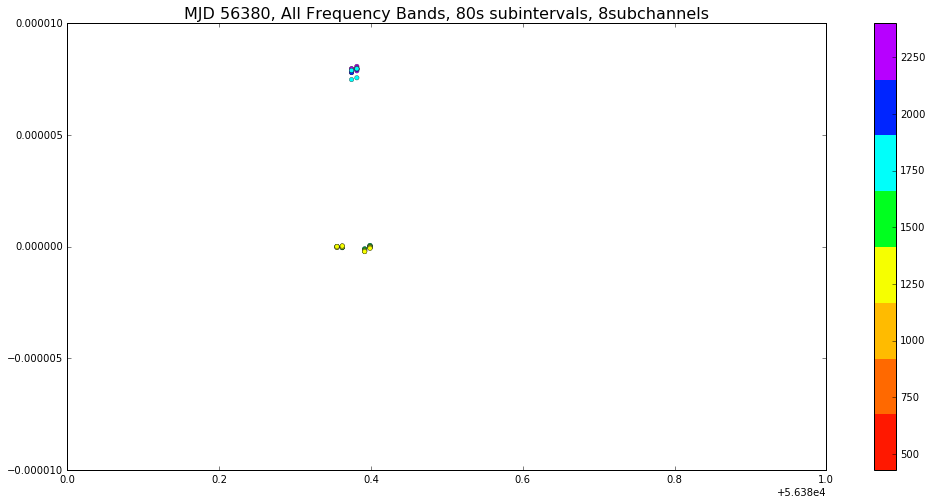

IOError: [Errno 2] No such file or directory: 'products/resid_NTF8.tmp'

In [102]:
## Testing RESIDFLAG
jitterpipe('/nimrod1/eschwab/J1713_data/', 'J1713+0747', 56380, clearoutput=False, cal=False, zap=False, scrunch=False, timing=False, resids=True)

In [104]:
## Testing the whole thing
jitterpipe('/nimrod1/eschwab/J1713_data/', 'J1713+0747', 56380, clearoutput=True, cal=True, zap=True, scrunch=True, timing=True, resids=True)

jitterpipe: Running J1713+0747 jitterpipe reduction pipeline
jitterpipe: Deleting old version
jitterpipe: Deletion complete
jitterpipe: Generating pulsar calibrators
jitterpipe: Generating calibrator database
jitterpipe: Calibrating fits files
jitterpipe: Calibration complete
jitterpipe: Moving calibrated files
jitterpipe: Removing RFI (this may take awhile)
jitterpipe: Zapping complete
jitterpipe: Making 10s-->80s, 256-->8 channel files


KeyboardInterrupt: 

In [107]:
## Testing the whole thing
jitterpipe('/nimrod1/eschwab/B1937_data/', 'B1937+21', 57376, clearoutput=True, cal=True, zap=True, scrunch=True, timing=True, resids=True)

jitterpipe: Running B1937+21 jitterpipe reduction pipeline
jitterpipe: Deleting old version
jitterpipe: Deletion complete
jitterpipe: Generating pulsar calibrators
jitterpipe: Generating calibrator database
jitterpipe: Calibrating fits files
jitterpipe: Calibration complete
jitterpipe: Moving calibrated files
jitterpipe: Removing RFI (this may take awhile)
jitterpipe: Zapping complete
jitterpipe: Making 10s-->80s, 256-->8 channel files
jitterpipe: Making 256-->8 channel, no tscrunch files
jitterpipe: Splitting complete
jitterpipe: Producing timing solution
jitterpipe: Writing master tim file for 80s subint + 8 channel files
jitterpipe: Writing daily tim file for 10s subint + 8 channel files
jitterpipe: Writing master tim file for 10s subint + 8 channel files
jitterpipe: Timing solution complete
jitterpipe: Running tempo
jitterpipe: Residuals generated
jitterpipe: Generating Plots for specified MJD


IOError: [Errno 2] No such file or directory: 'products/resid_80F8.tmp'

In [112]:
## Added a bunch of fun new directory items to above, so testing one by one again
jitterpipe('/nimrod1/eschwab/B1937_data/', 'B1937+21', 57376, clearoutput=True, cal=False, zap=False, scrunch=False, timing=False, resids=False)

jitterpipe: Running B1937+21 jitterpipe reduction pipeline
jitterpipe: Deleting old version
jitterpipe: Deletion complete
jitterpipe: Jitterpipe complete


In [116]:
## Now testing CALFLAG
jitterpipe('/nimrod1/eschwab/B1937_data/', 'B1937+21', 57376, clearoutput=False, cal=True, zap=False, scrunch=False, timing=False, resids=False)

jitterpipe: Running B1937+21 jitterpipe reduction pipeline
jitterpipe: Generating pulsar calibrators
jitterpipe: Generating calibrator database
jitterpipe: Calibrating fits files
jitterpipe: Calibration complete
jitterpipe: Moving calibrated files
jitterpipe: Jitterpipe complete


In [119]:
## Now testing CALFLAG
jitterpipe('/nimrod1/eschwab/B1937_data/', 'B1937+21', 57376, clearoutput=False, cal=False, zap=True, scrunch=False, timing=False, resids=False)

jitterpipe: Running B1937+21 jitterpipe reduction pipeline
jitterpipe: Removing RFI (this may take awhile)
jitterpipe: Zapping complete
jitterpipe: Jitterpipe complete


In [120]:
## Now testing SPLITFLAG
jitterpipe('/nimrod1/eschwab/B1937_data/', 'B1937+21', 57376, clearoutput=False, cal=False, zap=False, scrunch=True, timing=False, resids=False)

jitterpipe: Running B1937+21 jitterpipe reduction pipeline
jitterpipe: Making 10s-->80s, 256-->8 channel files
jitterpipe: Making 256-->8 channel, no tscrunch files
jitterpipe: Splitting complete
jitterpipe: Jitterpipe complete


In [135]:
## Now testing TIMFLAG
jitterpipe('/nimrod1/eschwab/B1937_data/', 'B1937+21', 57376, clearoutput=False, cal=False, zap=False, scrunch=False, timing=True, resids=False)

jitterpipe: Running B1937+21 jitterpipe reduction pipeline
jitterpipe: Producing timing solution
jitterpipe: Writing master tim file for 80s subint + 8 channel files
jitterpipe: Writing daily tim file for 10s subint + 8 channel files
[56020, 56059, 56108, 56139, 56173, 56209, 56250, 56284, 56305, 56325, 56345, 56383, 56403, 56425, 56446, 56465, 56531, 56532, 56550, 56571, 56572, 56593, 56613, 56634, 56654, 56669, 56739, 56755, 56844, 56869, 56887, 56933, 56970, 57014, 57075, 57095, 57117, 57138, 57185, 57201, 57234, 57242, 57265, 57327, 57348, 57376]
jitterpipe: Writing master tim file for 10s subint + 8 channel files
jitterpipe: Timing solution complete
jitterpipe: Jitterpipe complete


In [143]:
## Now testing TIMFLAG
jitterpipe('/nimrod1/eschwab/B1937_data/', 'B1937+21', 57376, clearoutput=False, cal=False, zap=False, scrunch=False, timing=False, resids=True)

jitterpipe: Running B1937+21 jitterpipe reduction pipeline
jitterpipe: Running tempo
tempo -G -f /nimrod1/eschwab/B1937_data/B1937+21_NANOGrav_11yv0.par /nimrod1/eschwab/B1937_data/master_B1937+21_NANOGrav_11y_80F8.tim 
jitterpipe: Jitterpipe complete


In [144]:
#Since I don't know if the trouble with residflag is pulsar specific, I will run on J1713 all the way through.
## Testing the whole thing
jitterpipe('/nimrod1/eschwab/J1713_data/', 'J1713+0747', 56380, clearoutput=True, cal=True, zap=True, scrunch=True, timing=True, resids=True)

jitterpipe: Running J1713+0747 jitterpipe reduction pipeline
jitterpipe: Deleting old version
jitterpipe: Deletion complete
jitterpipe: Generating pulsar calibrators
jitterpipe: Generating calibrator database
jitterpipe: Calibrating fits files
jitterpipe: Calibration complete
jitterpipe: Moving calibrated files
jitterpipe: Removing RFI (this may take awhile)
jitterpipe: Zapping complete
jitterpipe: Making 10s-->80s, 256-->8 channel files
jitterpipe: Making 256-->8 channel, no tscrunch files
jitterpipe: Splitting complete
jitterpipe: Producing timing solution
jitterpipe: Writing master tim file for 80s subint + 8 channel files
jitterpipe: Writing daily tim file for 10s subint + 8 channel files
jitterpipe: Writing master tim file for 10s subint + 8 channel files
jitterpipe: Timing solution complete
jitterpipe: Running tempo
tempo -G -f /nimrod1/eschwab/J1713_data/J1713+0747_NANOGrav_11yv0.par /nimrod1/eschwab/J1713_data/master_J1713+0747_NANOGrav_11y_80F8.tim 
jitterpipe: Jitterpipe comp

In [166]:
jitterpipe('/nimrod1/eschwab/J1713_data/', 'J1713+0747', 56380, clearoutput=False, cal=False, zap=False, scrunch=False, timing=False, resids=True)

jitterpipe: Running J1713+0747 jitterpipe reduction pipeline
jitterpipe: Running tempo
55989
tempo -G -f /nimrod1/eschwab/J1713_data/J1713+0747_NANOGrav_11yv0.par /nimrod1/eschwab/J1713_data/55989_J1713+0747_NANOGrav_11y_NTF8.tim
55994
tempo -G -f /nimrod1/eschwab/J1713_data/J1713+0747_NANOGrav_11yv0.par /nimrod1/eschwab/J1713_data/55994_J1713+0747_NANOGrav_11y_NTF8.tim
56023
tempo -G -f /nimrod1/eschwab/J1713_data/J1713+0747_NANOGrav_11yv0.par /nimrod1/eschwab/J1713_data/56023_J1713+0747_NANOGrav_11y_NTF8.tim
56038
tempo -G -f /nimrod1/eschwab/J1713_data/J1713+0747_NANOGrav_11yv0.par /nimrod1/eschwab/J1713_data/56038_J1713+0747_NANOGrav_11y_NTF8.tim
56044
tempo -G -f /nimrod1/eschwab/J1713_data/J1713+0747_NANOGrav_11yv0.par /nimrod1/eschwab/J1713_data/56044_J1713+0747_NANOGrav_11y_NTF8.tim
56057
tempo -G -f /nimrod1/eschwab/J1713_data/J1713+0747_NANOGrav_11yv0.par /nimrod1/eschwab/J1713_data/56057_J1713+0747_NANOGrav_11y_NTF8.tim
56106
tempo -G -f /nimrod1/eschwab/J1713_data/J1713+074